# Data Exploration Notebook for Quora Question Pairs

In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk import word_tokenize, ngrams
from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
import xgboost as xgb

%matplotlib inline

eng_stopwords = set(stopwords.words('english'))
# http://seaborn.pydata.org/tutorial/color_palettes.html
color = sns.color_palette()

pd.options.mode.chained_assignment = None  # default='warn'


Reading in the data:

In [21]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
submission_df = pd.read_csv("./sample_submission.csv")
print("train.csv ((rows, columns), size in Bytes): " + str(train_df.shape) + ", " + str(os.path.getsize('./train.csv')))
print("test.csv ((rows, columns), size in Bytes): " + str(test_df.shape) + ", " + str(os.path.getsize('./test.csv')))
print("sample_submission.csv ((rows, columns), size in Bytes): " + str(submission_df.shape) + ", " + str(os.path.getsize('./sample_submission.csv')))

train.csv ((rows, columns), size in Bytes): (404290, 6), 63399110
test.csv ((rows, columns), size in Bytes): (2345796, 3), 314015127
sample_submission.csv ((rows, columns), size in Bytes): (2345796, 2), 22346871


File sizes:

* train.csv: 63 MB
* test.csv: 314 MB
* sample_submission.csv: 22MB

The **training set** has 404290 rows and 6 columns, namely:

* **id** - the id of a training set question pair
* **qid1, qid2** - unique ids of each question (only available in train.csv)
* **question1, question2** - the full text of each question
* **is_duplicate** - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

The **test set** has 2345796 rows and 3 columns, namely:

* **test_id** - the id of a test set question pair
* **question1, question2** - the full text of each question

The **sample submission** has the same amount of rows as the test set (obviously) and only 2 columns, namely:

* **test_id** - the id of a test set question pair
* **is_duplicate** - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

In [3]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
test_df.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [5]:
submission_df.head()

,test_id,is_duplicate
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


## Target Variable Exploration

Target variable distribution:

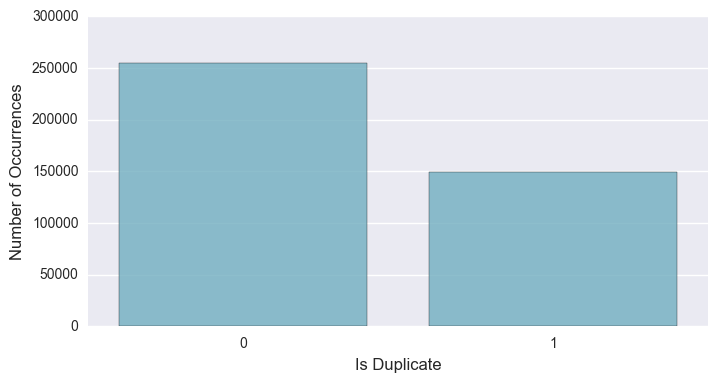

In [26]:
is_dup = train_df['is_duplicate'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(is_dup.index, is_dup.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Is Duplicate', fontsize=12)
plt.show()

In [27]:
is_dup / is_dup.sum()

0    0.630802
1    0.369198
Name: is_duplicate, dtype: float64

So we have about 63% non-duplicate questions and 37% duplicate questions in the training data set.

## Questions Exploration

Now let us explore the question fields present in the train data. First let us check the number of words distribution in the questions.

In [28]:
all_ques_df = pd.DataFrame(pd.concat([train_df['question1'], train_df['question2']]))
all_ques_df.columns = ["questions"]

all_ques_df["num_of_words"] = all_ques_df["questions"].apply(lambda x : len(str(x).split()))

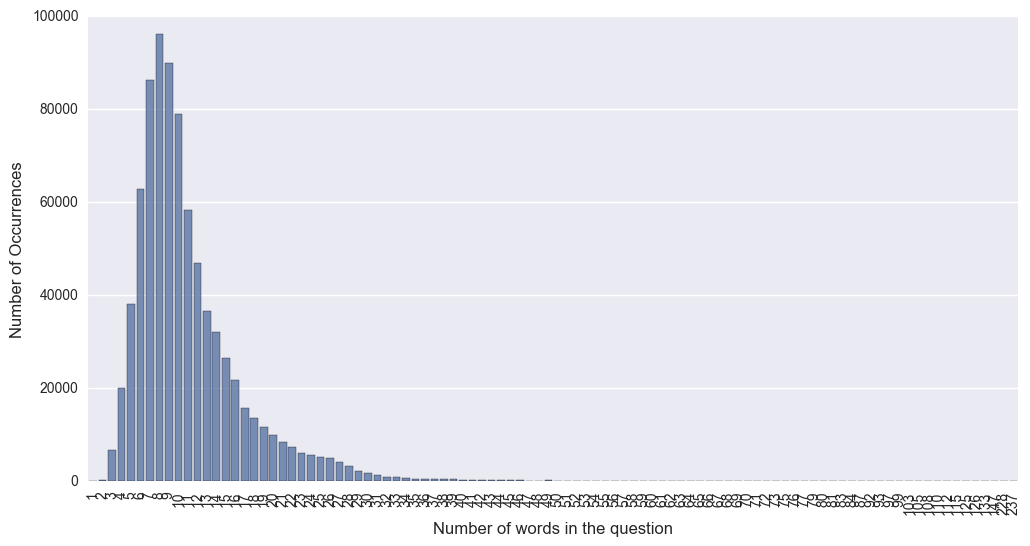

In [29]:
cnt_srs = all_ques_df['num_of_words'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of words in the question', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

So the distribution is right skewed with upto 237 words in a question. There are also few questions with 1 or 2 words as well.

Now let us explore the number of characters distribution as well.

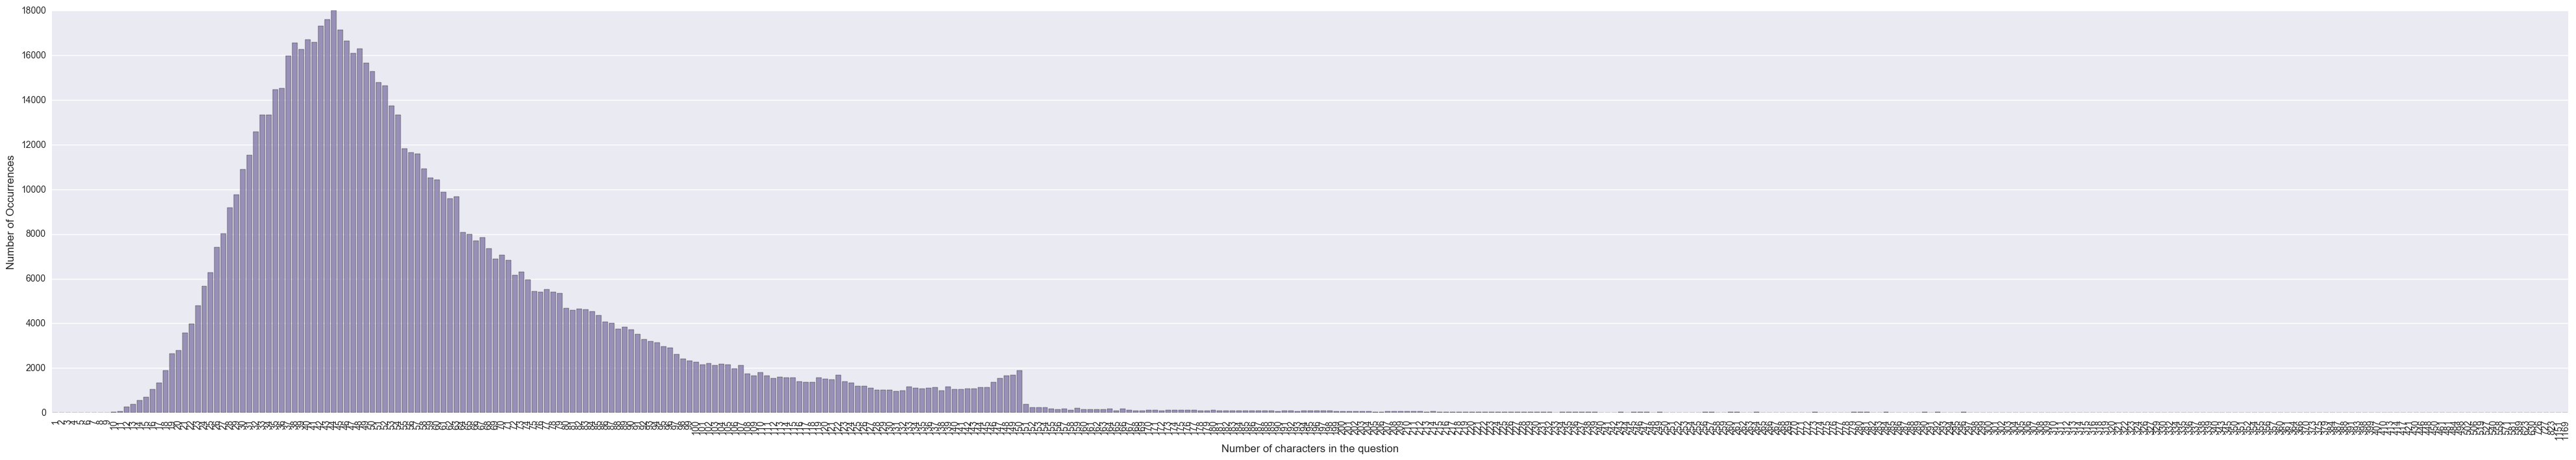

In [30]:
all_ques_df["num_of_chars"] = all_ques_df["questions"].apply(lambda x : len(str(x)))
cnt_srs = all_ques_df['num_of_chars'].value_counts()

plt.figure(figsize=(50,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of characters in the question', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()      

del all_ques_df

Number of characters distribution as well is right skewed.
One interesting point is the sudden dip at the 150 character mark. This is due to Quora's new restriction on the maximum size of characters in a question which is 150 characters.
Now let us look at the distribution of common unigrams between the given question pairs.

In [31]:
def get_unigrams(que):
    return [word for word in word_tokenize(que.lower()) if word not in eng_stopwords]

def get_common_unigrams(row):
    return len( set(row["unigrams_ques1"]).intersection(set(row["unigrams_ques2"])) )

def get_common_unigram_ratio(row):
    return float(row["unigrams_common_count"]) / max(len( set(row["unigrams_ques1"]).union(set(row["unigrams_ques2"])) ),1)

train_df["unigrams_ques1"] = train_df['question1'].apply(lambda x: get_unigrams(str(x)))
train_df["unigrams_ques2"] = train_df['question2'].apply(lambda x: get_unigrams(str(x)))
train_df["unigrams_common_count"] = train_df.apply(lambda row: get_common_unigrams(row),axis=1)
train_df["unigrams_common_ratio"] = train_df.apply(lambda row: get_common_unigram_ratio(row), axis=1)

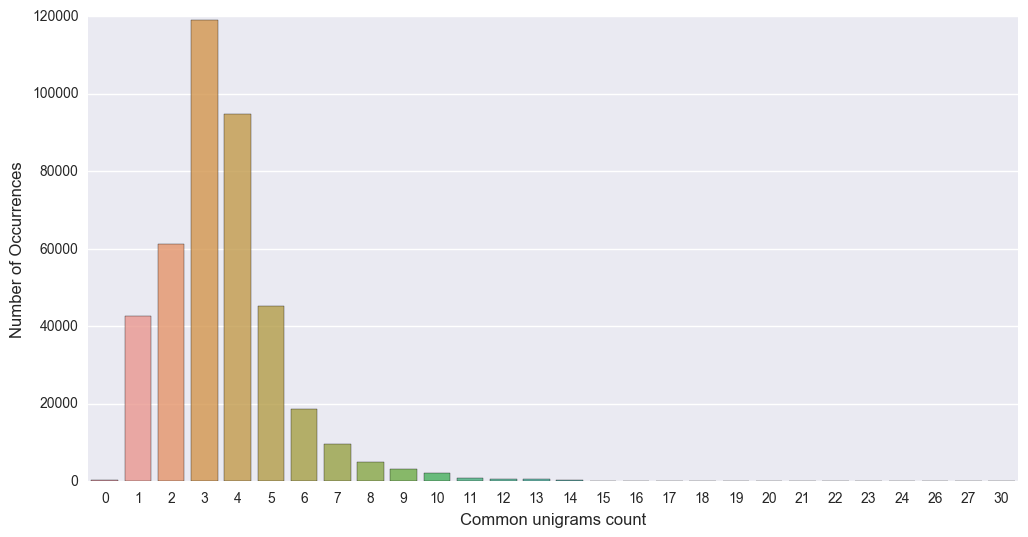

In [32]:
cnt_srs = train_df['unigrams_common_count'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Common unigrams count', fontsize=12)
plt.show()

It is interesting to see that there are very few question pairs with no common words.

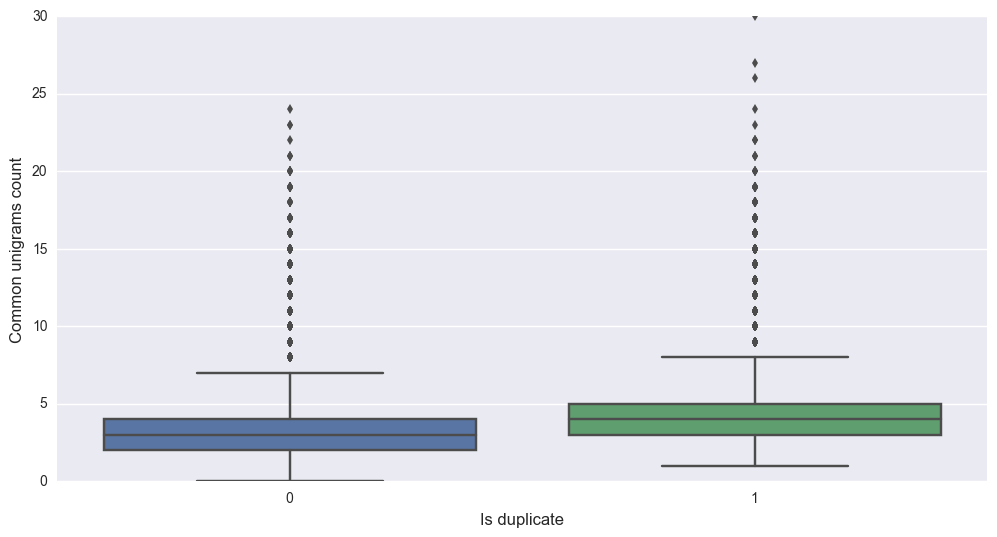

In [33]:
plt.figure(figsize=(12,6))
sns.boxplot(x="is_duplicate", y="unigrams_common_count", data=train_df)
plt.xlabel('Is duplicate', fontsize=12)
plt.ylabel('Common unigrams count', fontsize=12)
plt.show()

There is some good difference between 0 and 1 class using the common unigram count variable. Let us look at the same graph using common unigrams ratio.

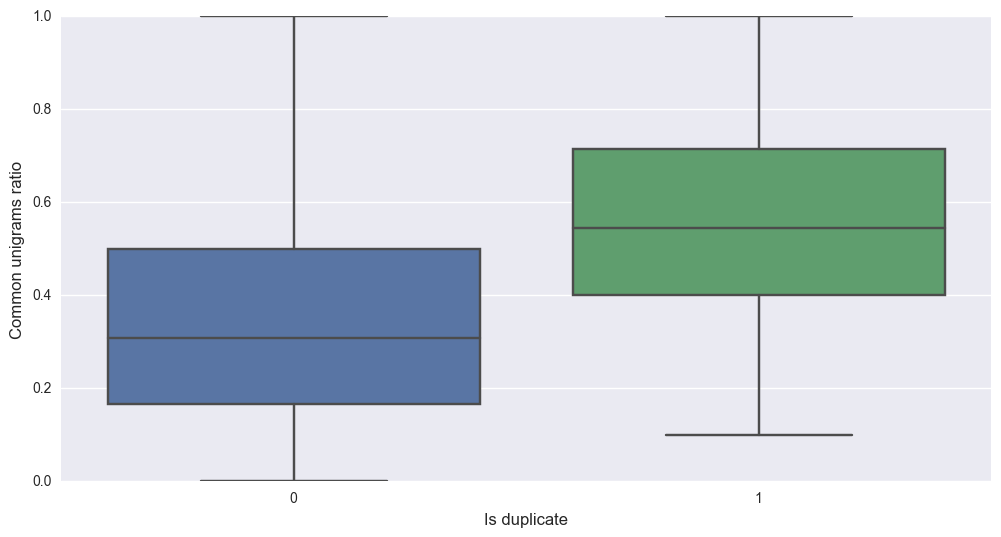

In [34]:
plt.figure(figsize=(12,6))
sns.boxplot(x="is_duplicate", y="unigrams_common_ratio", data=train_df)
plt.xlabel('Is duplicate', fontsize=12)
plt.ylabel('Common unigrams ratio', fontsize=12)
plt.show()